--- 1. Loading Features and Labels ---
Successfully loaded features from: /home/zihend1/Genesis/KNOT/data/processed/final_gene_druggability_features.tsv
Features DataFrame shape: (19244, 507)
Successfully loaded raw labels from: /home/zihend1/Genesis/KNOT/data/gene_graph.pt
Combined DataFrame shape (features + binary label): (19032, 506)
Unlabeled samples (0): 14721
Labeled (Tier) samples (1): 4311

--- 2. Visualizing Feature Distributions ---
Plotting distributions for the first 20 features (or all if fewer) to check for perfect separation.


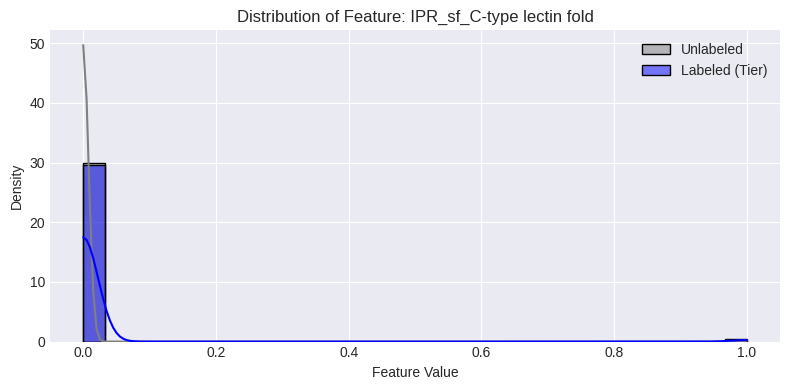

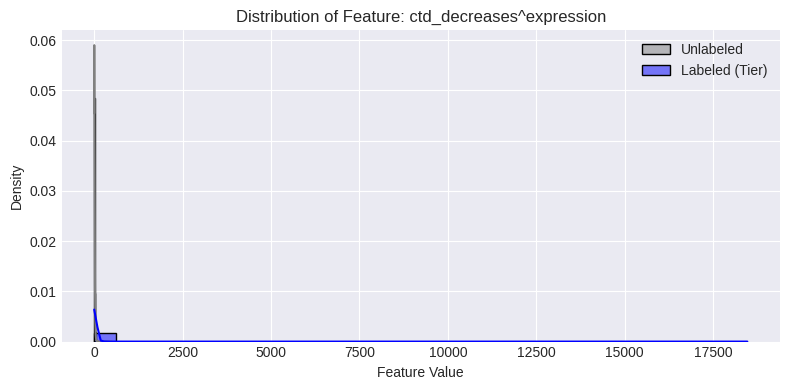

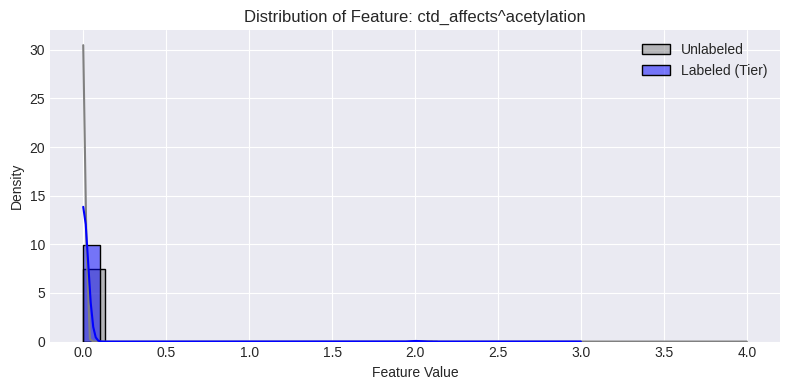

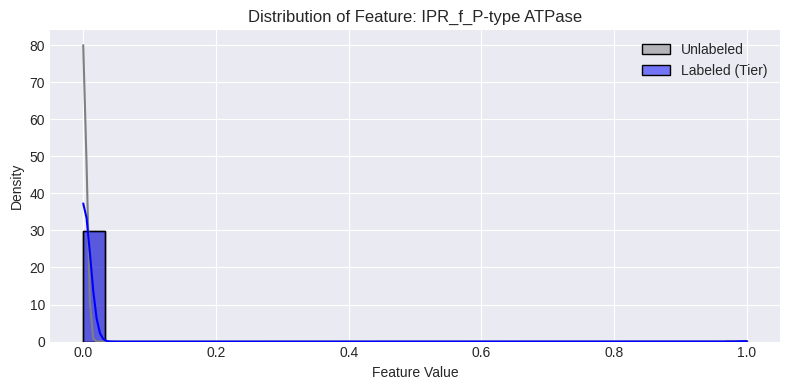

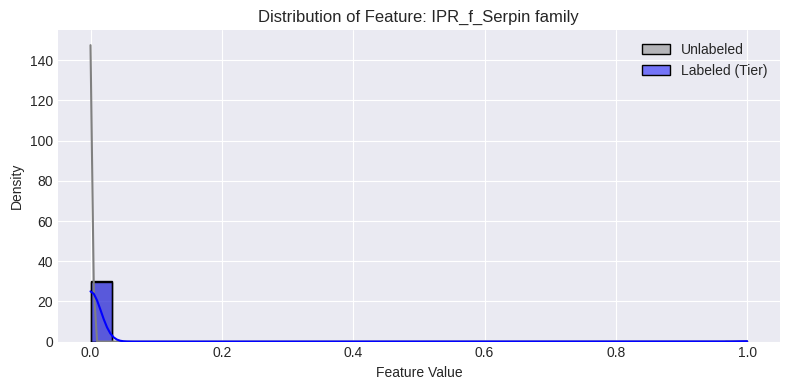

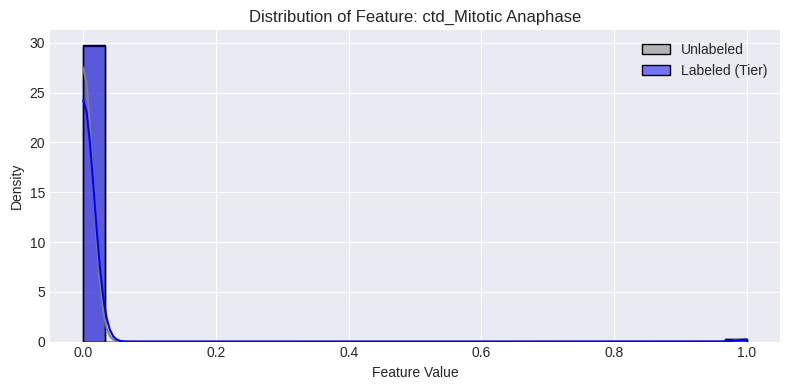

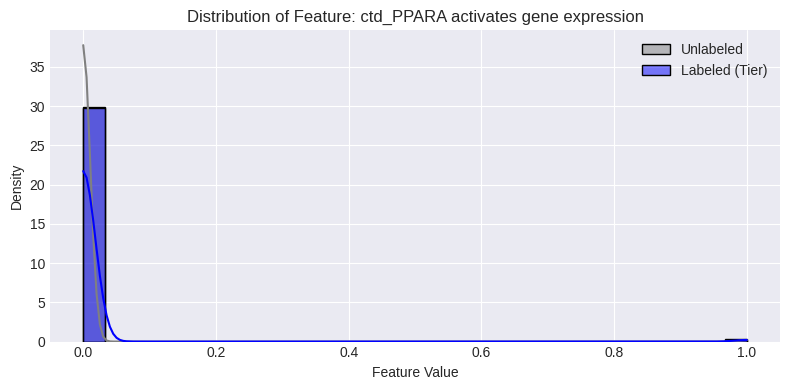

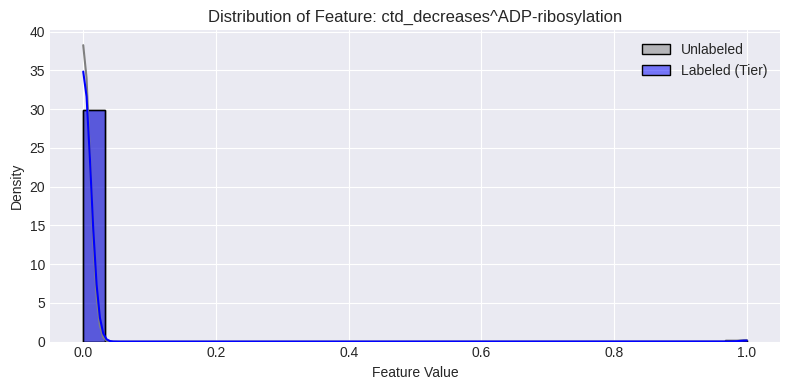

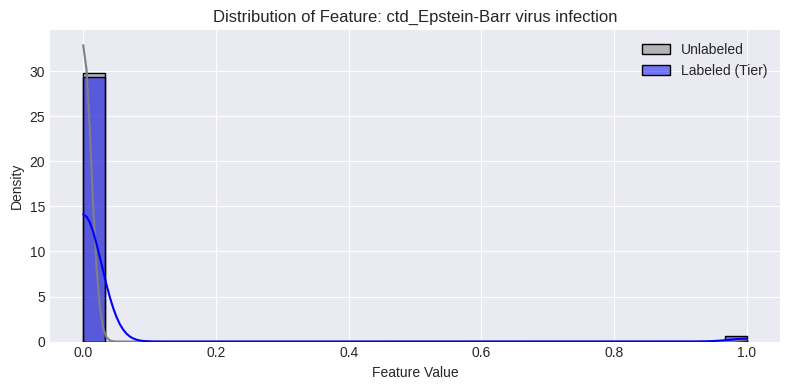

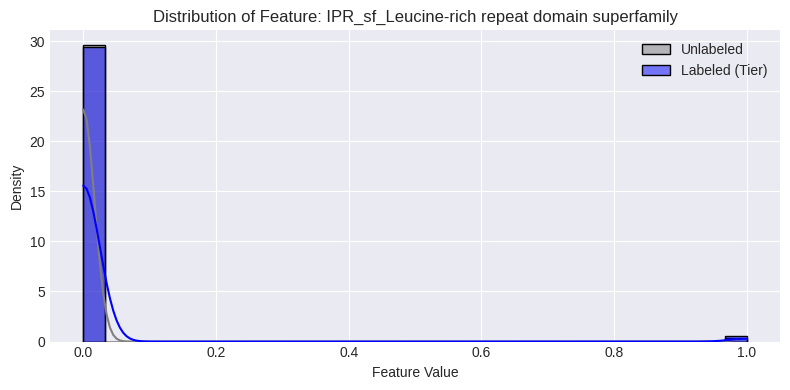

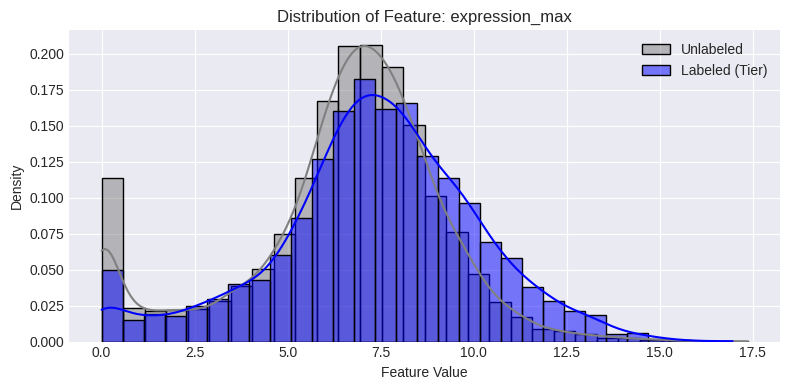

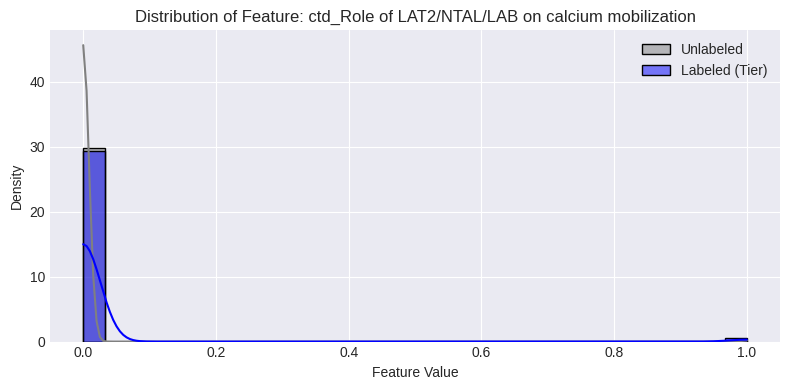

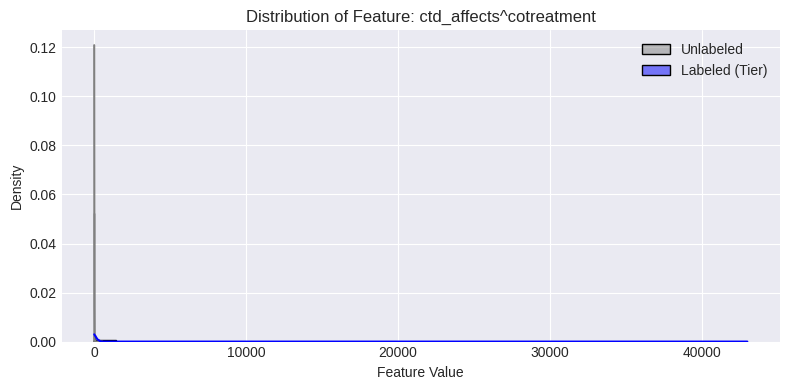

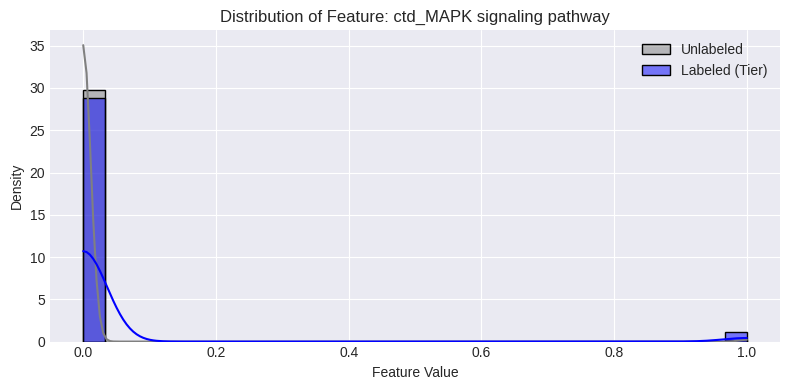

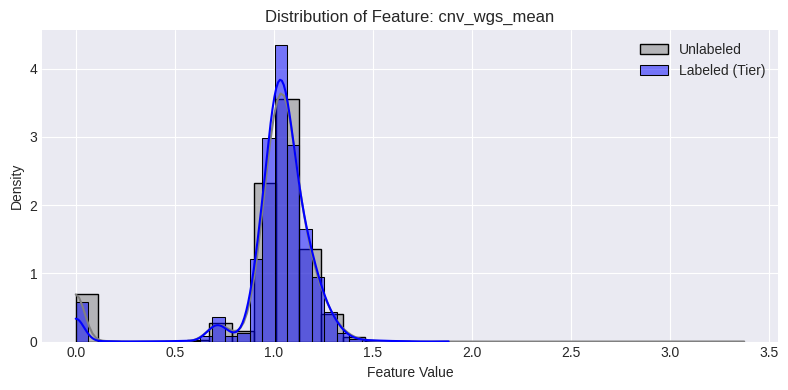

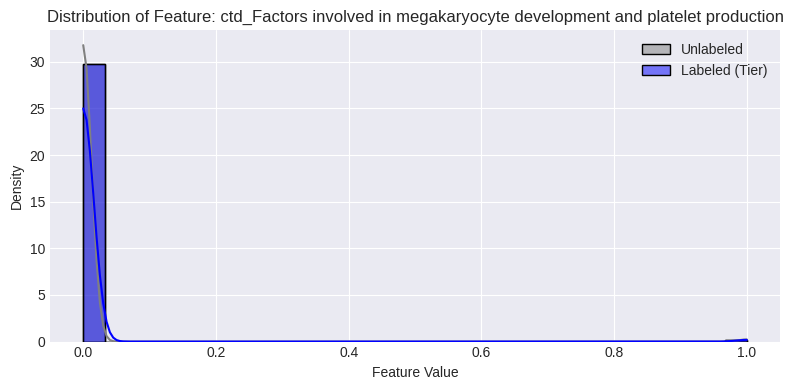

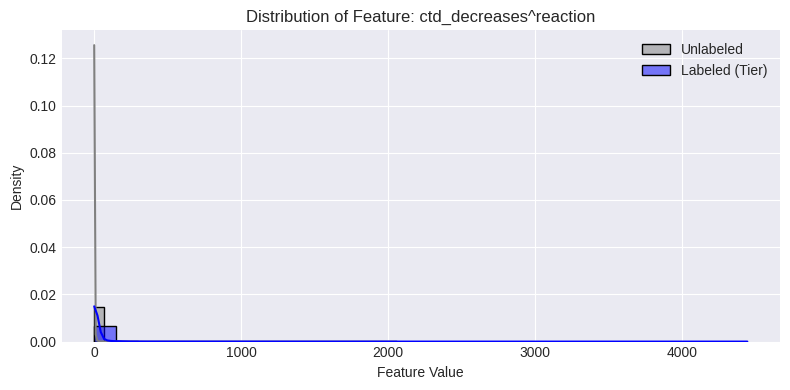

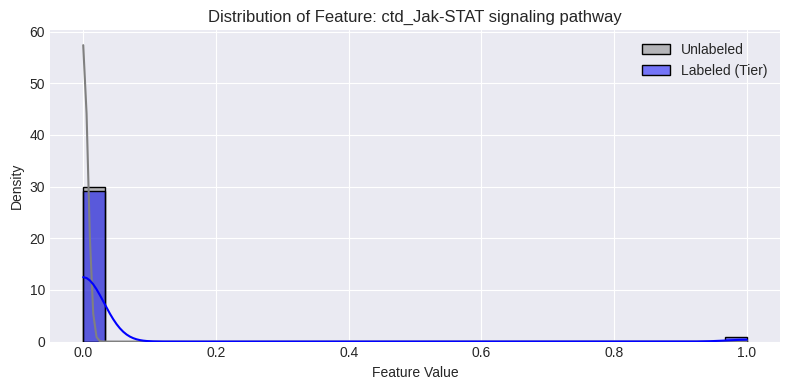

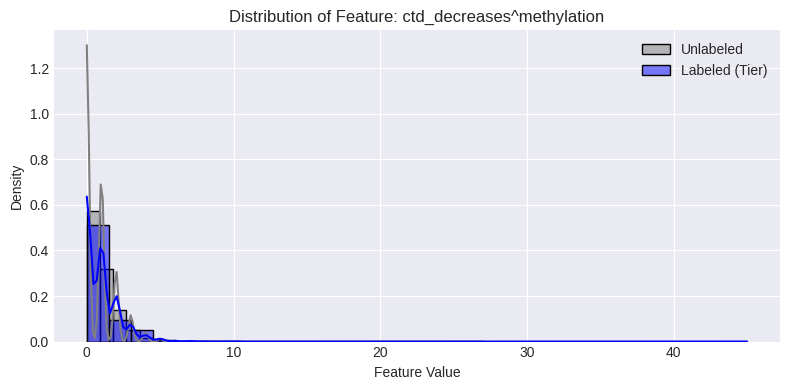

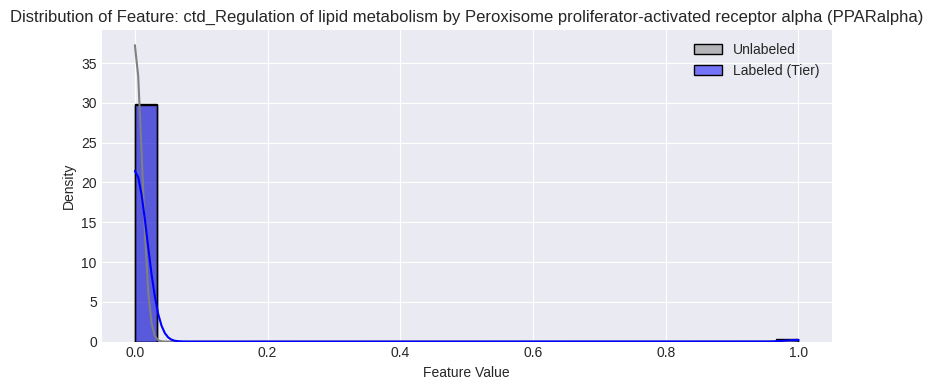


--- 3. Final Thoughts ---
通过观察上述特征分布图，请特别留意那些：
1. **两个类别（Unlabeled 和 Labeled）的直方图完全不重叠的特征。** 如果发现这样的特征，那么它就是导致你模型准确率 100% 的直接原因。这是一种非常明显的数据泄漏。
2. **一个类别（例如 Unlabeled）只在一个非常窄的范围内有值，而另一个类别（Labeled）在完全不同的窄范围内有值的特征。** 这也是强烈的泄漏信号。
如果发现了这样的特征，你需要追溯这个特征是如何生成或收集的，并确定它是否无意中编码了标签信息。
解决数据泄漏是确保模型泛化能力的关键一步。


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch # To load data.y from the graph if needed, or directly from data.y_raw
import os
import warnings
warnings.filterwarnings('ignore') # Suppress warnings for cleaner output

# --- Paths (Ensure these are correct) ---
FEATURE_TSV = "/home/zihend1/Genesis/KNOT/data/processed/final_gene_druggability_features.tsv"
GRAPH_PATH = "/home/zihend1/Genesis/KNOT/data/gene_graph.pt" # Used to get the y labels

# --- 1. Load Features and Labels ---
print("--- 1. Loading Features and Labels ---")

try:
    df_features = pd.read_csv(FEATURE_TSV, sep="\t")
    print(f"Successfully loaded features from: {FEATURE_TSV}")
    print(f"Features DataFrame shape: {df_features.shape}")
except FileNotFoundError:
    print(f"Error: Feature file not found at {FEATURE_TSV}. Please check the path.")
    exit()
except Exception as e:
    print(f"An error occurred while loading features: {e}")
    exit()

# Load y labels from the generated graph data (or directly from source if available)
try:
    graph_data = torch.load(GRAPH_PATH)
    y_raw = np.array(graph_data.y)
    print(f"Successfully loaded raw labels from: {GRAPH_PATH}")
except FileNotFoundError:
    print(f"Error: Graph file not found at {GRAPH_PATH}. Please ensure it's generated.")
    exit()
except Exception as e:
    print(f"An error occurred while loading labels from graph: {e}")
    exit()

# Ensure Gene_Symbol is the index for merging
if "Gene_Symbol" in df_features.columns:
    df_features = df_features.set_index("Gene_Symbol")
else:
    print("Warning: 'Gene_Symbol' column not found in feature TSV. Assuming first column is gene identifier.")
    # Attempt to use the first column as index if Gene_Symbol is missing
    df_features = df_features.set_index(df_features.columns[0])

# Align labels with features based on Gene_Symbol
# Create a DataFrame for labels, using Gene_Symbol from the features df
# Assuming the order of genes in df_features matches the order in graph_data.y
# This is a critical assumption. If not, you need to merge by Gene_Symbol.
df_labels = pd.DataFrame({'Gene_Symbol': graph_data.y.index, 'y_raw': y_raw}) # This line needs adjustment if graph_data.y is not a Series with index
# A more robust way:
# First, get the gene symbols that correspond to the features in df_features
genes_in_features = df_features.index.tolist()
# Then, filter y_raw based on these genes if y_raw is ordered by genes
# Or, if y_raw is from the graph, it's already aligned with x.
# The simplest is to use the `df` that was used to build the graph, as it has both features and labels.

# Let's re-read df as in build_gene_graph.py to ensure alignment
df_graph_build = pd.read_csv(FEATURE_TSV, sep="\t")
valid_genes_path = "/home/zihend1/Genesis/KNOT/data/symbol/valid_gene_symbols.tsv"
valid_genes = pd.read_csv(valid_genes_path, header=None, names=["Gene_Symbol"])["Gene_Symbol"].tolist()
df_graph_build = df_graph_build[df_graph_build["Gene_Symbol"].isin(valid_genes)]
df_graph_build = df_graph_build.drop_duplicates(subset="Gene_Symbol")
df_graph_build = df_graph_build.set_index("Gene_Symbol")

# Ensure the features used for x are correctly identified
all_columns_graph_build = df_graph_build.columns.tolist()
feature_cols = [c for c in all_columns_graph_build if c not in ["druggability_tier", "idgTDL"]]
label_type = "druggability_tier" # As per your build_gene_graph.py

# Create the combined DataFrame with features and binary labels
df_combined = df_graph_build[feature_cols].copy()
df_combined['y_raw'] = df_graph_build[label_type].fillna("-1")

# Convert raw labels to binary (Unlabeled vs. Labeled)
df_combined['y_binary'] = np.where(df_combined['y_raw'] == '-1', 0, 1)
binary_class_names = ["Unlabeled", "Labeled (Tier)"]

print(f"Combined DataFrame shape (features + binary label): {df_combined.shape}")
print(f"Unlabeled samples (0): {np.sum(df_combined['y_binary'] == 0)}")
print(f"Labeled (Tier) samples (1): {np.sum(df_combined['y_binary'] == 1)}")


# --- 2. Visualize Feature Distributions by Binary Label ---
print("\n--- 2. Visualizing Feature Distributions ---")
print("Plotting distributions for the first 20 features (or all if fewer) to check for perfect separation.")

num_features_to_plot = min(20, len(feature_cols))
selected_features = np.random.choice(feature_cols, num_features_to_plot, replace=False) # Randomly select features

plt.style.use('seaborn-v0_8-darkgrid') # Ensure consistent style for plots
sns.set_palette("tab10") # A distinct palette for binary groups

for i, feature in enumerate(selected_features):
    plt.figure(figsize=(8, 4))
    
    # Plot distribution for Unlabeled (Class 0)
    sns.histplot(df_combined[df_combined['y_binary'] == 0][feature], 
                 color='gray', label=binary_class_names[0], kde=True, stat='density', alpha=0.5, bins=30)
    
    # Plot distribution for Labeled (Class 1)
    sns.histplot(df_combined[df_combined['y_binary'] == 1][feature], 
                 color='blue', label=binary_class_names[1], kde=True, stat='density', alpha=0.5, bins=30)
    
    plt.title(f'Distribution of Feature: {feature}')
    plt.xlabel('Feature Value')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Check for perfect separation (e.g., no overlap in value ranges)
    min_unlabeled = df_combined[df_combined['y_binary'] == 0][feature].min()
    max_unlabeled = df_combined[df_combined['y_binary'] == 0][feature].max()
    min_labeled = df_combined[df_combined['y_binary'] == 1][feature].min()
    max_labeled = df_combined[df_combined['y_binary'] == 1][feature].max()

    if (max_unlabeled < min_labeled) or (max_labeled < min_unlabeled):
        print(f"--- ALERT: Feature '{feature}' shows PERFECT SEPARATION in value ranges! ---")
        print(f"  Unlabeled range: [{min_unlabeled:.2f}, {max_unlabeled:.2f}]")
        print(f"  Labeled range:   [{min_labeled:.2f}, {max_labeled:.2f}]")
        print("  This feature is a strong candidate for data leakage.")
    elif (min_unlabeled <= max_labeled and max_unlabeled >= min_labeled): # Check for any overlap
        if not (min_labeled <= max_unlabeled and max_labeled >= min_unlabeled): # If ranges are not fully nested
             print(f"  Feature '{feature}' ranges overlap. Unlabeled: [{min_unlabeled:.2f}, {max_unlabeled:.2f}], Labeled: [{min_labeled:.2f}, {max_labeled:.2f}]")
    else:
        print(f"  Feature '{feature}' ranges overlap. Unlabeled: [{min_unlabeled:.2f}, {max_unlabeled:.2f}], Labeled: [{min_labeled:.2f}, {max_labeled:.2f}]")


# --- 3. Final Thoughts ---
print("\n--- 3. Final Thoughts ---")
print("通过观察上述特征分布图，请特别留意那些：")
print("1. **两个类别（Unlabeled 和 Labeled）的直方图完全不重叠的特征。** 如果发现这样的特征，那么它就是导致你模型准确率 100% 的直接原因。这是一种非常明显的数据泄漏。")
print("2. **一个类别（例如 Unlabeled）只在一个非常窄的范围内有值，而另一个类别（Labeled）在完全不同的窄范围内有值的特征。** 这也是强烈的泄漏信号。")
print("如果发现了这样的特征，你需要追溯这个特征是如何生成或收集的，并确定它是否无意中编码了标签信息。")
print("解决数据泄漏是确保模型泛化能力的关键一步。")

--- 1. Setup and Data Loading ---
Successfully loaded feature names: 504 features.
Successfully loaded data. Feature dimension: 504

--- 2. Label Processing for Binary Classification ---
Total samples: 19032
Unlabeled samples (Class 0): 14721
Labeled (Tier) samples (Class 1): 4311
Data has been standardized.

--- 3. Data Splitting ---
Data split into training/testing sets and standardized.

--- 4. Train Logistic Regression for Coefficient Analysis ---


Logistic Regression model trained.

--- 5. Analyze Feature Coefficients ---

--- Top 10 Most Influential Features (by absolute coefficient value) ---
                                               Feature  Coefficient  \
503                                         known_gene     5.915885   
81                             DGIdb_interaction_types     0.510806   
294        ctd_Neuroactive ligand-receptor interaction     0.324503   
111                             ctd_decreases^activity     0.252909   
83                            Re_L2_seed_genes_overlap     0.231573   
399  string_db_L1_protein_seed_genes_overlap_weight...     0.196006   
426                        IPR_d_Protein kinase domain     0.170440   
189           ctd_Class A/1 (Rhodopsin-like receptors)     0.143202   
193         ctd_Cytokine-cytokine receptor interaction     0.135213   
485      IPR_sf_Protein kinase-like domain superfamily     0.132867   

     Abs_Coefficient  
503         5.915885  
81          0.510806  

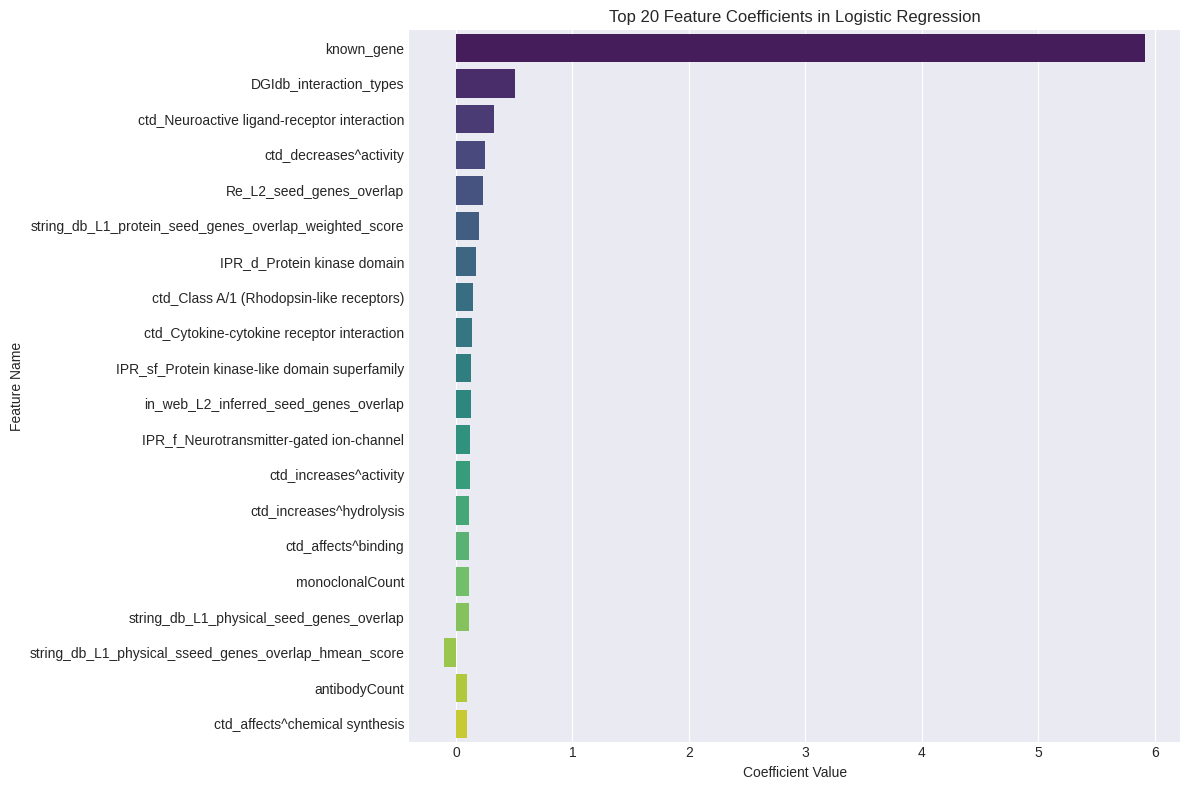


--- 6. Enhanced PCA Visualization ---
Explained variance ratio of first 2 principal components: 0.1197


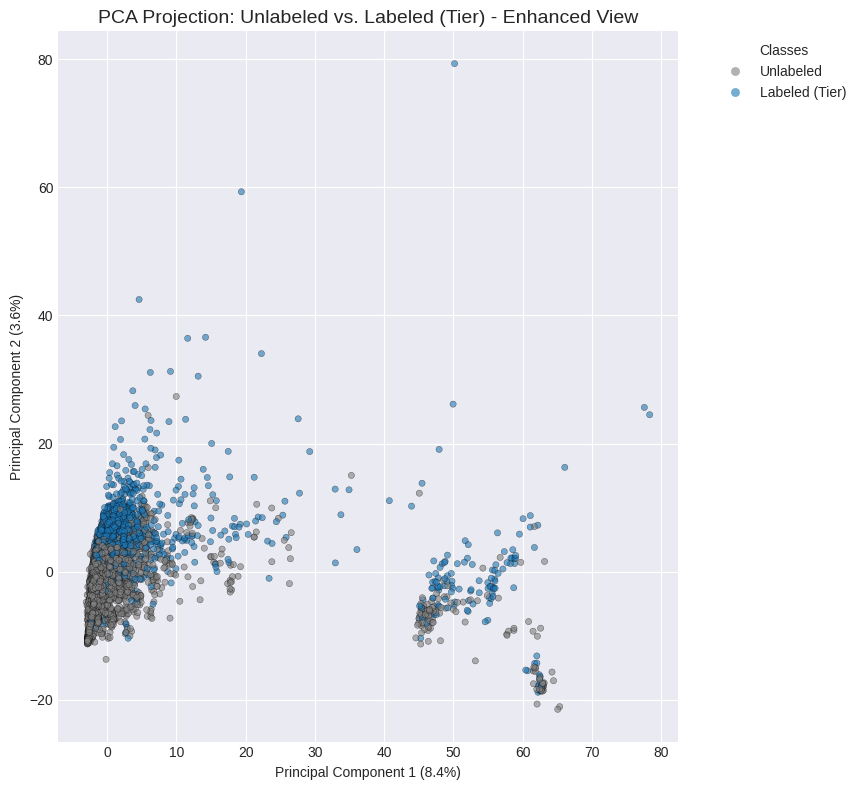


--- 7. Enhanced UMAP Visualization ---


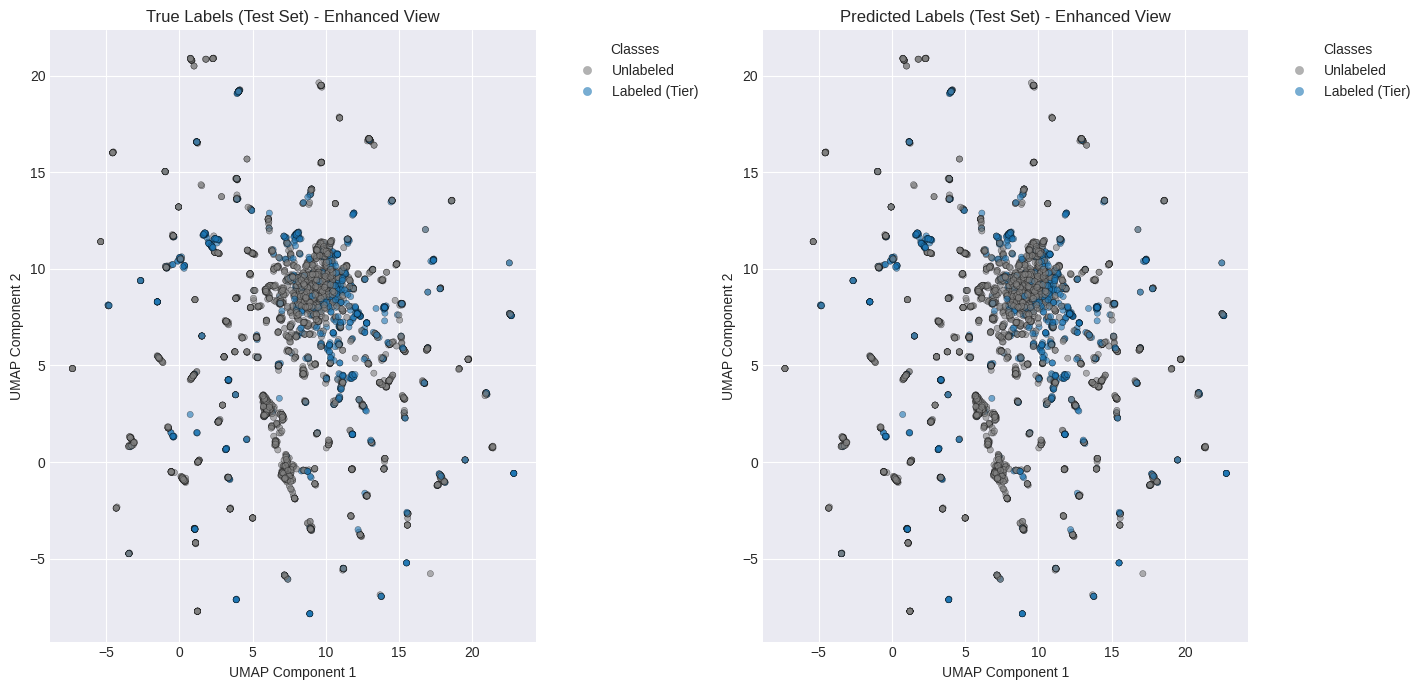


--- Visualization and Analysis Complete ---


In [5]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import umap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA # Import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_curve, auc,
    precision_recall_curve, average_precision_score
)
from matplotlib.colors import ListedColormap
import warnings

warnings.filterwarnings('ignore') # Suppress warnings for cleaner output

# --- 1. Setup and Data Loading ---
print("--- 1. Setup and Data Loading ---")

# Set plotting style and color palette
plt.style.use('seaborn-v0_8-darkgrid')
# Use a distinct palette for binary groups (adjust if you prefer different colors)
# We will explicitly define colors for better control with ListedColormap
# sns.set_palette("husl") 

# Define data path
GRAPH_PATH = "/home/zihend1/Genesis/KNOT/data/gene_graph.pt"
FEATURE_TSV = "/home/zihend1/Genesis/KNOT/data/processed/final_gene_druggability_features.tsv"
VALID_TSV = "/home/zihend1/Genesis/KNOT/data/symbol/valid_gene_symbols.tsv" # Needed to get feature names

# Load original features dataframe to get column names for coefficient mapping
try:
    df_raw_features = pd.read_csv(FEATURE_TSV, sep="\t")
    valid_genes = pd.read_csv(VALID_TSV, header=None, names=["Gene_Symbol"])["Gene_Symbol"].tolist()
    df_raw_features = df_raw_features[df_raw_features["Gene_Symbol"].isin(valid_genes)]
    df_raw_features = df_raw_features.drop_duplicates(subset="Gene_Symbol")
    
    all_raw_cols = df_raw_features.columns.tolist()
    feature_cols = [c for c in all_raw_cols if c not in ["Gene_Symbol", "druggability_tier", "idgTDL"]]
    print(f"Successfully loaded feature names: {len(feature_cols)} features.")
except FileNotFoundError:
    print(f"Error: Feature or valid gene file not found. Paths used: {FEATURE_TSV}, {VALID_TSV}")
    exit()
except Exception as e:
    print(f"An error occurred while loading raw features for column names: {e}")
    exit()

# Load X_all and y_binary from the graph as before
try:
    data = torch.load(GRAPH_PATH)
    if torch.isnan(data.x).any():
        data.x[torch.isnan(data.x)] = 0
    X_all = data.x.cpu().numpy()
    y_raw = np.array(data.y) 
    print(f"Successfully loaded data. Feature dimension: {X_all.shape[1]}")
except FileNotFoundError:
    print(f"Error: Graph file not found. Please check the path: {GRAPH_PATH}")
    exit() 
except Exception as e:
    print(f"An error occurred while loading data from graph: {e}")
    exit()

# --- 2. Label Processing for Binary Classification ---
print("\n--- 2. Label Processing for Binary Classification ---")

y_binary = np.where(y_raw == '-1', 0, 1) 
binary_class_names = ["Unlabeled", "Labeled (Tier)"]

print(f"Total samples: {len(X_all)}")
print(f"Unlabeled samples (Class 0): {np.sum(y_binary == 0)}")
print(f"Labeled (Tier) samples (Class 1): {np.sum(y_binary == 1)}")

# Standardize data
scaler = StandardScaler()
X_all_scaled = scaler.fit_transform(X_all)
print("Data has been standardized.")

# --- 3. Data Splitting (for Classification Model) ---
print("\n--- 3. Data Splitting ---")
indices = np.arange(len(X_all))
X_train, X_test, y_train_binary, y_test_binary, train_indices, test_indices = train_test_split(
    X_all, y_binary, indices, test_size=0.2, stratify=y_binary, random_state=42
)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("Data split into training/testing sets and standardized.")


# --- 4. Train Logistic Regression (for coefficient analysis) ---
print("\n--- 4. Train Logistic Regression for Coefficient Analysis ---")
clf = LogisticRegression(max_iter=1000, solver='liblinear', random_state=42)
clf.fit(X_train_scaled, y_train_binary)
print("Logistic Regression model trained.")


# --- 5. Analyze Feature Coefficients ---
print("\n--- 5. Analyze Feature Coefficients ---")
coefficients = clf.coef_[0] 
coef_df = pd.DataFrame({
    'Feature': feature_cols,
    'Coefficient': coefficients
})
coef_df['Abs_Coefficient'] = np.abs(coef_df['Coefficient'])
coef_df_sorted = coef_df.sort_values(by='Abs_Coefficient', ascending=False)

print("\n--- Top 10 Most Influential Features (by absolute coefficient value) ---")
print(coef_df_sorted.head(10))

print("\n--- Bottom 10 Least Influential Features (by absolute coefficient value) ---")
print(coef_df_sorted.tail(10))

num_top_features_to_plot = 20 
plt.figure(figsize=(12, 8))
sns.barplot(x='Coefficient', y='Feature', data=coef_df_sorted.head(num_top_features_to_plot), palette='viridis')
plt.title(f'Top {num_top_features_to_plot} Feature Coefficients in Logistic Regression')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature Name')
plt.tight_layout()
plt.show()


# --- 6. Enhanced PCA Visualization ---
print("\n--- 6. Enhanced PCA Visualization ---")

pca_reducer = PCA(n_components=2, random_state=42)
X_pca = pca_reducer.fit_transform(X_all_scaled)
print(f"Explained variance ratio of first 2 principal components: {pca_reducer.explained_variance_ratio_.sum():.4f}")

# Define custom colormaps for binary classes
binary_cmap_list = ['#808080', '#1f77b4'] # Gray for Unlabeled, Blue for Labeled
custom_binary_cmap = ListedColormap(binary_cmap_list)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_binary, 
                     cmap=custom_binary_cmap, 
                     s=20,          # Smaller point size
                     alpha=0.6,     # Increased transparency
                     edgecolors='k', # Black edge for better distinction
                     linewidth=0.3)  # Thin edge line

plt.title('PCA Projection: Unlabeled vs. Labeled (Tier) - Enhanced View', fontsize=14)
plt.xlabel(f'Principal Component 1 ({pca_reducer.explained_variance_ratio_[0]*100:.1f}%)')
plt.ylabel(f'Principal Component 2 ({pca_reducer.explained_variance_ratio_[1]*100:.1f}%)')

legend_elements = scatter.legend_elements()
plt.legend(handles=legend_elements[0], labels=binary_class_names, 
           title="Classes", loc="upper left", bbox_to_anchor=(1.05, 1))
plt.grid(True)
plt.tight_layout(rect=[0, 0, 0.88, 1]) 
plt.show()


# --- 7. Enhanced UMAP Visualization ---
print("\n--- 7. Enhanced UMAP Visualization ---")

# Using a common UMAP parameter set for this visualization (from previous runs)
umap_reducer = umap.UMAP(n_components=2, n_neighbors=30, min_dist=0.1, random_state=42)
X_umap_all = umap_reducer.fit_transform(X_all_scaled)

# Get UMAP coordinates for the test set
X_test_umap = X_umap_all[test_indices]
y_pred_binary = clf.predict(X_test_scaled) # Re-use prediction from trained clf

fig, axes = plt.subplots(1, 2, figsize=(16, 7)) # Slightly wider figure

# Plot True Labels on UMAP
ax = axes[0]
scatter = ax.scatter(X_test_umap[:, 0], X_test_umap[:, 1], c=y_test_binary, 
                     cmap=custom_binary_cmap, 
                     s=20,          # Smaller point size
                     alpha=0.6,     # Increased transparency
                     edgecolors='k', # Black edge for better distinction
                     linewidth=0.3)  # Thin edge line
ax.set_title('True Labels (Test Set) - Enhanced View', fontsize=12)
ax.set_xlabel('UMAP Component 1')
ax.set_ylabel('UMAP Component 2')
legend_elements_true = scatter.legend_elements()
ax.legend(handles=legend_elements_true[0], labels=binary_class_names, 
                    title="Classes", loc="upper left", bbox_to_anchor=(1.05, 1))

# Plot Predicted Labels on UMAP
ax = axes[1]
scatter = ax.scatter(X_test_umap[:, 0], X_test_umap[:, 1], c=y_pred_binary, 
                     cmap=custom_binary_cmap, 
                     s=20,          # Smaller point size
                     alpha=0.6,     # Increased transparency
                     edgecolors='k', # Black edge for better distinction
                     linewidth=0.3)  # Thin edge line
ax.set_title('Predicted Labels (Test Set) - Enhanced View', fontsize=12)
ax.set_xlabel('UMAP Component 1')
ax.set_ylabel('UMAP Component 2')
legend_elements_pred = scatter.legend_elements()
ax.legend(handles=legend_elements_pred[0], labels=binary_class_names, 
                    title="Classes", loc="upper left", bbox_to_anchor=(1.05, 1))

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()

print("\n--- Visualization and Analysis Complete ---")

In [7]:
df_raw_features

,Gene_Symbol,crispr_dependency_mean,crispr_dependency_std,crispr_dependency_min,crispr_dependency_max,crispr_dependency_median,crispr_dependency_strong_count,cnv_wgs_mean,cnv_wgs_std,cnv_wgs_min,...,IPR_sf_WD40/YVTN repeat-like-containing domain superfamily,IPR_sf_Winged helix DNA-binding domain superfamily,IPR_sf_Winged helix-like DNA-binding domain superfamily,IPR_sf_Zinc finger C2H2 superfamily,"IPR_sf_Zinc finger, FYVE/PHD-type","IPR_sf_Zinc finger, RING/FYVE/PHD-type",IPR_sf_von Willebrand factor A-like domain superfamily,known_gene,druggability_tier,idgTDL
0,A1BG,-0.061496,0.106872,-0.626283,0.464101,-0.058588,1.0,1.089149,0.324947,0.353139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Tier 3B,Tbio
1,A1CF,-0.068786,0.103610,-0.826178,0.412459,-0.066809,4.0,1.006446,0.243072,0.448895,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1,Tbio
2,A2M,0.033482,0.097134,-0.331599,0.428117,0.032418,0.0,1.107545,0.297580,0.375062,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Tier 3B,Tbio
3,A2ML1,0.068928,0.098860,-0.376827,0.480926,0.067592,0.0,1.022944,0.275505,0.316907,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Tier 3A,Tbio
4,A3GALT2,-0.099010,0.125272,-0.672216,0.383656,-0.090788,4.0,0.966693,0.197476,0.296045,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1,Tdark
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19239,ZYG11A,-0.047944,0.102375,-0.431871,0.571468,-0.050927,0.0,1.003897,0.191902,0.333292,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1,Tdark
19240,ZYG11B,-0.140896,0.127530,-0.806002,0.410633,-0.139932,8.0,1.006239,0.200860,0.475033,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1,Tdark
19241,ZYX,-0.043318,0.128729,-0.532427,0.370096,-0.034781,2.0,1.094383,0.298147,0.350219,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1,Tbio
19242,ZZEF1,-0.140179,0.119869,-0.622824,0.305158,-0.139425,10.0,0.965827,0.237389,0.000005,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1,Tdark


--- 1. Setup and Data Loading ---
Successfully loaded feature names: 504 features.
Successfully loaded data. Feature dimension: 504

--- 2. Label Processing for Binary Classification ---
Total samples: 19032
Unlabeled samples (Class 0): 14721
Labeled (Tier) samples (Class 1): 4311

--- 3. Data Splitting and Standardization ---
Data split into training/testing sets and standardized.

--- 4. Train a Simple Binary Classifier (Logistic Regression) ---
Logistic Regression model trained successfully.

--- 5. Model Evaluation and Statistics ---

--- Classification Report ---
                precision    recall  f1-score   support

     Unlabeled       1.00      1.00      1.00      2945
Labeled (Tier)       1.00      1.00      1.00       862

      accuracy                           1.00      3807
     macro avg       1.00      1.00      1.00      3807
  weighted avg       1.00      1.00      1.00      3807


--- Confusion Matrix ---
[[2944    1]
 [   0  862]]


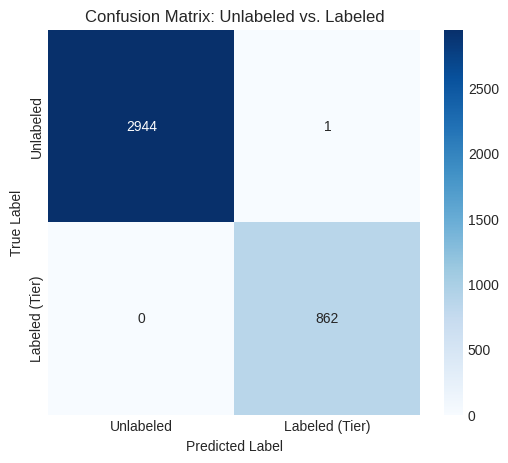


--- ROC Curve and AUC ---
ROC AUC: 1.0000


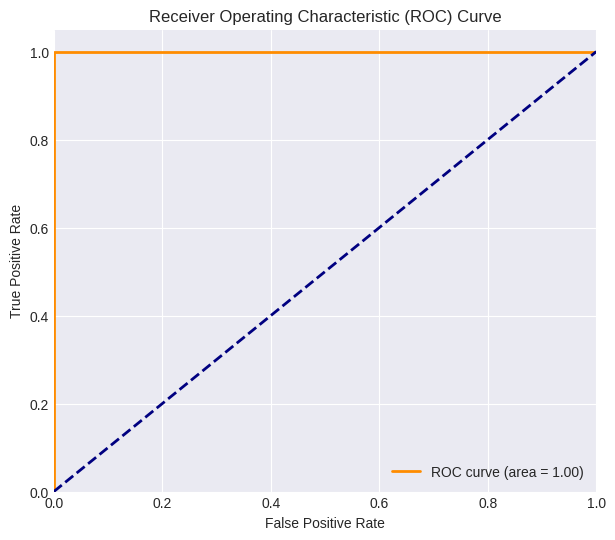


--- Precision-Recall Curve and AP Score ---
Average Precision (AP / PR-AUC): 1.0000


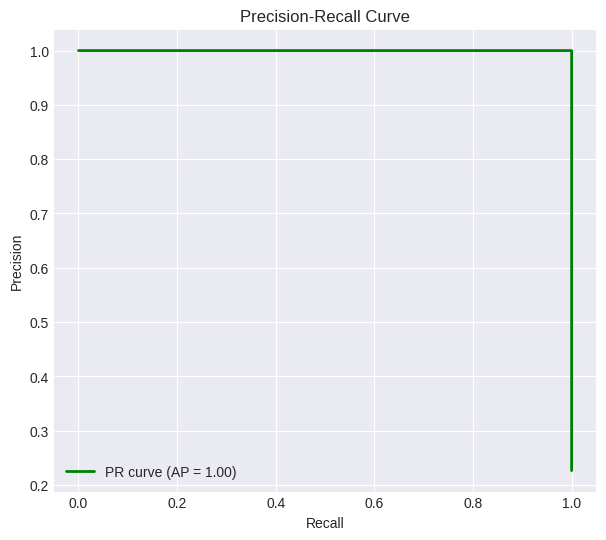


--- 6. Analyze Feature Coefficients ---

--- Top 10 Most Influential Features (by absolute coefficient value) ---
                                               Feature  Coefficient  \
503                                         known_gene     5.915885   
81                             DGIdb_interaction_types     0.510806   
294        ctd_Neuroactive ligand-receptor interaction     0.324503   
111                             ctd_decreases^activity     0.252909   
83                            Re_L2_seed_genes_overlap     0.231573   
399  string_db_L1_protein_seed_genes_overlap_weight...     0.196006   
426                        IPR_d_Protein kinase domain     0.170440   
189           ctd_Class A/1 (Rhodopsin-like receptors)     0.143202   
193         ctd_Cytokine-cytokine receptor interaction     0.135213   
485      IPR_sf_Protein kinase-like domain superfamily     0.132867   

     Abs_Coefficient  
503         5.915885  
81          0.510806  
294         0.324503  
111        

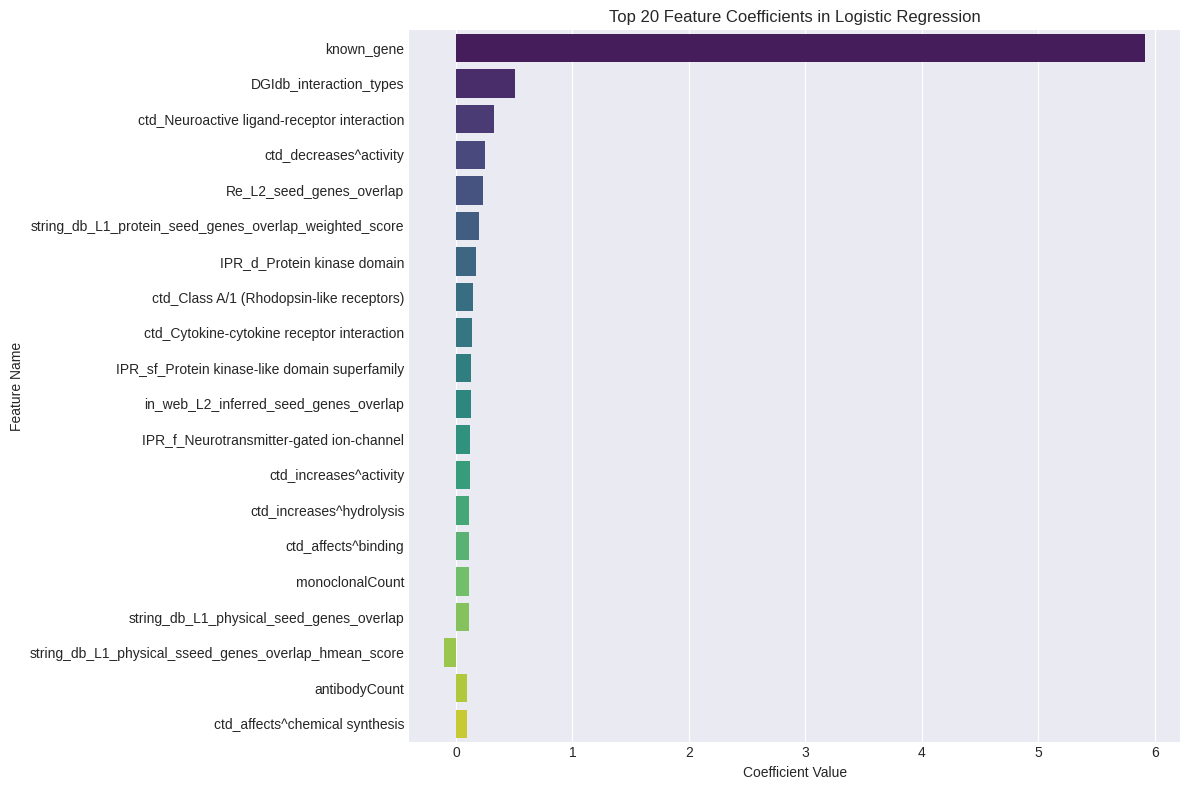


--- 7. Visualize Classification Results on UMAP Projection ---
Generating UMAP embedding for visualization (n_neighbors=30, min_dist=0.1)...


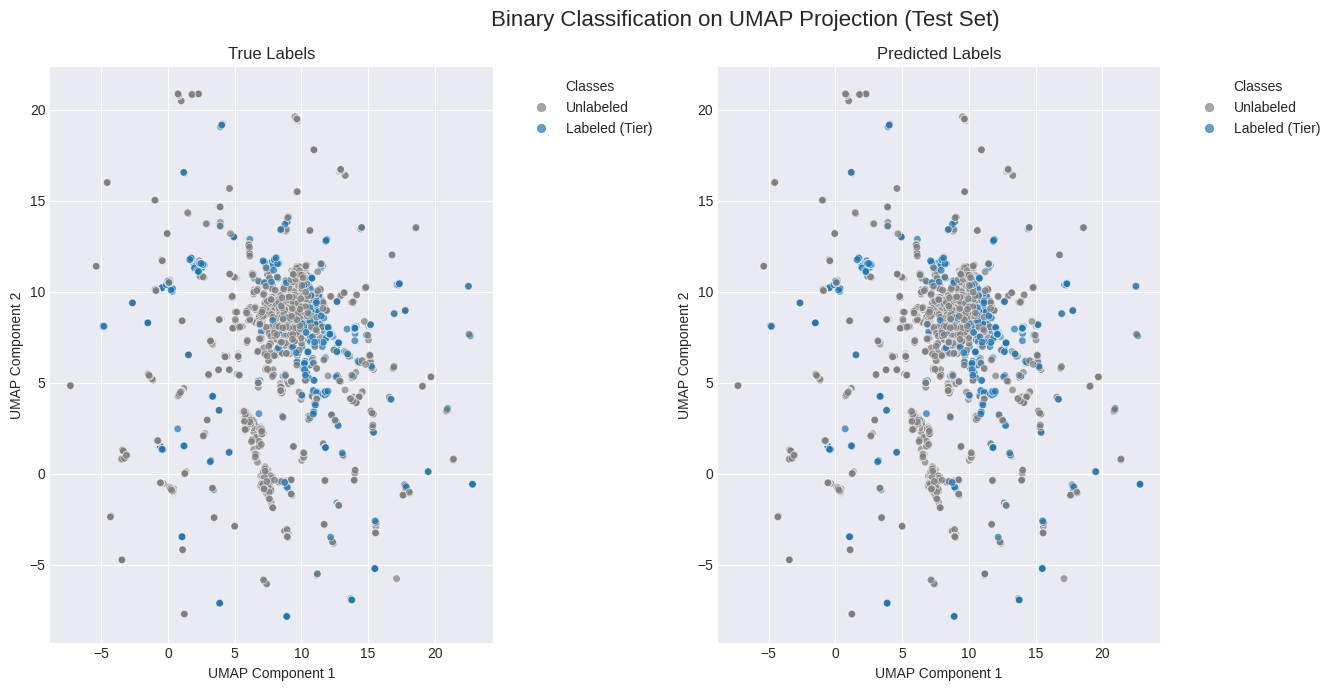


--- Binary Classification Analysis Complete ---


In [4]:
import torch
import numpy as np
import pandas as pd # Import pandas for DataFrame operations
import matplotlib.pyplot as plt
import seaborn as sns
import umap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_curve, auc,
    precision_recall_curve, average_precision_score
)
from matplotlib.colors import ListedColormap
import warnings

warnings.filterwarnings('ignore') # Suppress warnings for cleaner output

# --- 1. Setup and Data Loading ---
print("--- 1. Setup and Data Loading ---")

# Set plotting style and color palette
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl") 

# Define data path
GRAPH_PATH = "/home/zihend1/Genesis/KNOT/data/gene_graph.pt"
FEATURE_TSV = "/home/zihend1/Genesis/KNOT/data/processed/final_gene_druggability_features.tsv"
VALID_TSV = "/home/zihend1/Genesis/KNOT/data/symbol/valid_gene_symbols.tsv" # Needed to get feature names

# Load original features dataframe to get column names for coefficient mapping
try:
    # This df is used just to extract original feature names.
    # It should reflect the same filtering/processing as in build_gene_graph.py
    df_raw_features = pd.read_csv(FEATURE_TSV, sep="\t")
    valid_genes = pd.read_csv(VALID_TSV, header=None, names=["Gene_Symbol"])["Gene_Symbol"].tolist()
    df_raw_features = df_raw_features[df_raw_features["Gene_Symbol"].isin(valid_genes)]
    df_raw_features = df_raw_features.drop_duplicates(subset="Gene_Symbol")
    
    # Extract feature column names (excluding Gene_Symbol and label columns)
    all_raw_cols = df_raw_features.columns.tolist()
    # Ensure these match the feature_cols defined in build_gene_graph.py
    feature_cols = [c for c in all_raw_cols if c not in ["Gene_Symbol", "druggability_tier", "idgTDL"]]
    print(f"Successfully loaded feature names: {len(feature_cols)} features.")
except FileNotFoundError:
    print(f"Error: Feature or valid gene file not found. Paths used: {FEATURE_TSV}, {VALID_TSV}")
    exit()
except Exception as e:
    print(f"An error occurred while loading raw features for column names: {e}")
    exit()

# Load X_all and y_binary from the graph as before
try:
    data = torch.load(GRAPH_PATH)
    if torch.isnan(data.x).any():
        data.x[torch.isnan(data.x)] = 0
    X_all = data.x.cpu().numpy()
    y_raw = np.array(data.y) # Load y_raw here to derive y_binary consistently
    print(f"Successfully loaded data. Feature dimension: {X_all.shape[1]}")
except FileNotFoundError:
    print(f"Error: Graph file not found. Please check the path: {GRAPH_PATH}")
    exit() 
except Exception as e:
    print(f"An error occurred while loading data from graph: {e}")
    exit()

# --- 2. Label Processing for Binary Classification ---
print("\n--- 2. Label Processing for Binary Classification ---")

y_binary = np.where(y_raw == '-1', 0, 1) 
binary_class_names = ["Unlabeled", "Labeled (Tier)"]

print(f"Total samples: {len(X_all)}")
print(f"Unlabeled samples (Class 0): {np.sum(y_binary == 0)}")
print(f"Labeled (Tier) samples (Class 1): {np.sum(y_binary == 1)}")

# --- 3. Data Splitting and Standardization ---
print("\n--- 3. Data Splitting and Standardization ---")

indices = np.arange(len(X_all))
X_train, X_test, y_train_binary, y_test_binary, train_indices, test_indices = train_test_split(
    X_all, y_binary, indices, test_size=0.2, stratify=y_binary, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("Data split into training/testing sets and standardized.")

# --- 4. Train a Simple Binary Classifier (Logistic Regression) ---
print("\n--- 4. Train a Simple Binary Classifier (Logistic Regression) ---")

clf = LogisticRegression(max_iter=1000, solver='liblinear', random_state=42)
clf.fit(X_train_scaled, y_train_binary)
print("Logistic Regression model trained successfully.")

y_pred_binary = clf.predict(X_test_scaled)
y_prob_binary = clf.predict_proba(X_test_scaled)[:, 1] 

# --- 5. Model Evaluation and Statistics (Previous code, kept for completeness) ---
print("\n--- 5. Model Evaluation and Statistics ---")

print("\n--- Classification Report ---")
print(classification_report(y_test_binary, y_pred_binary, target_names=binary_class_names))

print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_test_binary, y_pred_binary)
print(cm)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=binary_class_names, yticklabels=binary_class_names)
plt.title('Confusion Matrix: Unlabeled vs. Labeled')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print("\n--- ROC Curve and AUC ---")
fpr, tpr, thresholds = roc_curve(y_test_binary, y_prob_binary)
roc_auc = auc(fpr, tpr)
print(f"ROC AUC: {roc_auc:.4f}")
plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print("\n--- Precision-Recall Curve and AP Score ---")
precision, recall, _ = precision_recall_curve(y_test_binary, y_prob_binary)
ap_score = average_precision_score(y_test_binary, y_prob_binary)
print(f"Average Precision (AP / PR-AUC): {ap_score:.4f}")
plt.figure(figsize=(7, 6))
plt.plot(recall, precision, color='green', lw=2, label=f'PR curve (AP = {ap_score:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.grid(True)
plt.show()


# --- 6. Analyze Feature Coefficients (New Section) ---
print("\n--- 6. Analyze Feature Coefficients ---")

# Get the coefficients from the trained Logistic Regression model
# clf.coef_ is a 2D array for multi-class, but 1D for binary
coefficients = clf.coef_[0] 

# Create a DataFrame to easily associate coefficients with feature names
coef_df = pd.DataFrame({
    'Feature': feature_cols,
    'Coefficient': coefficients
})

# Sort by absolute value of coefficients to see the most influential features
coef_df['Abs_Coefficient'] = np.abs(coef_df['Coefficient'])
coef_df_sorted = coef_df.sort_values(by='Abs_Coefficient', ascending=False)

print("\n--- Top 10 Most Influential Features (by absolute coefficient value) ---")
print(coef_df_sorted.head(10))

print("\n--- Bottom 10 Least Influential Features (by absolute coefficient value) ---")
print(coef_df_sorted.tail(10))

# Visualize the top N coefficients
num_top_features_to_plot = 20 # You can adjust this number
plt.figure(figsize=(12, 8))
sns.barplot(x='Coefficient', y='Feature', data=coef_df_sorted.head(num_top_features_to_plot), palette='viridis')
plt.title(f'Top {num_top_features_to_plot} Feature Coefficients in Logistic Regression')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature Name')
plt.tight_layout()
plt.show()


# --- 7. Visualize Classification Results on UMAP Projection (Previous code, kept for completeness) ---
print("\n--- 7. Visualize Classification Results on UMAP Projection ---")

print("Generating UMAP embedding for visualization (n_neighbors=30, min_dist=0.1)...")
umap_reducer = umap.UMAP(n_components=2, n_neighbors=30, min_dist=0.1, random_state=42)
# Fit UMAP on the entire scaled dataset
X_umap_all = umap_reducer.fit_transform(X_all_scaled)

# Use the test_indices obtained from the train_test_split to get the UMAP coordinates for the test set
X_test_umap = X_umap_all[test_indices]

binary_cmap_list = ['#808080', '#1f77b4'] # Gray for Unlabeled, default blue for Labeled
custom_binary_cmap = ListedColormap(binary_cmap_list)

fig, axes = plt.subplots(1, 2, figsize=(15, 7))
fig.suptitle('Binary Classification on UMAP Projection (Test Set)', fontsize=16)

# Plot True Labels on UMAP
ax = axes[0]
scatter = ax.scatter(X_test_umap[:, 0], X_test_umap[:, 1], c=y_test_binary, 
                     cmap=custom_binary_cmap, s=30, alpha=0.7, edgecolors='w', linewidth=0.5)
ax.set_title('True Labels')
ax.set_xlabel('UMAP Component 1')
ax.set_ylabel('UMAP Component 2')
legend_elements_true = scatter.legend_elements()
ax.legend(handles=legend_elements_true[0], labels=binary_class_names, 
                    title="Classes", loc="upper left", bbox_to_anchor=(1.05, 1))

# Plot Predicted Labels on UMAP
ax = axes[1]
scatter = ax.scatter(X_test_umap[:, 0], X_test_umap[:, 1], c=y_pred_binary, 
                     cmap=custom_binary_cmap, s=30, alpha=0.7, edgecolors='w', linewidth=0.5)
ax.set_title('Predicted Labels')
ax.set_xlabel('UMAP Component 1')
ax.set_ylabel('UMAP Component 2')
legend_elements_pred = scatter.legend_elements()
ax.legend(handles=legend_elements_pred[0], labels=binary_class_names, 
                    title="Classes", loc="upper left", bbox_to_anchor=(1.05, 1))

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()

print("\n--- Binary Classification Analysis Complete ---")